In [1]:
# Import library yang digunakan
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_word = stopwords.words('english')
import re
import string
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# Load dataset pada Colaboratory
df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')            #baca dataset
df = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt']) #menghapus kolom yang tidak diperlukan
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [26]:
# Fungsi untuk mengubah jumlah kelas menjadi 3 kelas; pos, neg, neu
def change_sentiment(sentiment):
  if sentiment == "Extremely Positive":
    return 'Positive'
  elif sentiment == "Extremely Negative":
    return 'Negative'
  elif sentiment == "Positive":
    return 'Positive'
  elif sentiment == "Negative":
    return 'Negative'
  else:
    return 'Neutral'

In [128]:
# Preprocessing tweet
def cleansing(text):
  text = text.lower()
  #untuk menghapus urls, mentions, digits, html tags, tanda baca
  text = text.replace('&amp', ' ')
  text = text.replace('amp', ' ')
  text = re.sub(r'https?://\S+|www\.\S+', " ", text)
  text = re.sub(r'@\w+',' ',text)
  text = re.sub(r'\d+', ' ', text)
  text = re.sub('r<.*?>',' ', text)
  
  text = text.translate(str.maketrans(' ', ' ', string.punctuation))

  #untuk menghapus stop words 
  text = text.split()
  text = " ".join([word for word in text if not word in stop_word])  
  return text

In [43]:
# Mengganti tweet dengan tweet yang sudah dipreprocessing dan sentiment sesuai dengan kelas yang sudah ditentukan tadi
df['Sentiment'] = df['Sentiment'].apply(lambda x: change_sentiment(x))
df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: cleansing(x))

In [44]:
# Karena label kita berupa data kategorikal, maka kita perlu melakukan proses one-hot-encoding
category = pd.get_dummies(df.Sentiment)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Sentiment')
df_baru

,OriginalTweet,Negative,Neutral,Positive
0,,0,1,0
1,advice talk neighbours family exchange phone n...,0,0,1
2,coronavirus australia woolworths give elderly ...,0,0,1
3,food stock one empty please dont panic enough ...,0,0,1
4,ready go supermarket outbreak im paranoid food...,1,0,0
...,...,...,...,...
41152,airline pilots offering stock supermarket shel...,0,1,0
41153,response complaint provided citing covid relat...,1,0,0
41154,know itâs getting tough rationing toilet pape...,0,0,1
41155,wrong smell hand sanitizer starting turn,0,1,0


In [45]:
# Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values
tweet = df_baru['OriginalTweet'].values
label = df_baru[['Negative', 'Positive', 'Neutral']].values

In [47]:
# Membagi dataset untuk training dan validation
tweet_latih, tweet_validation, label_latih, label_validation = train_test_split(tweet, label, test_size=0.2)

print(tweet_latih.shape, label_latih.shape)
print(tweet_validation.shape, label_validation.shape)

(32925,) (32925, 3)
(8232,) (8232, 3)


In [75]:
# Agar teks dapat dipahami oleh model, kita harus lakukan tokenisasi

#ubah setiap kata pada dataset kita ke dalam bilangan numerik dengan fungsi Tokenizer
NUM_WORD = 10000
tokenizer = Tokenizer(num_words=NUM_WORD, oov_token='x')     #num_words: x kata tersering muncul
tokenizer.fit_on_texts(tweet_latih) 
# tokenizer.fit_on_texts(tweet_validation)

#mengonversi setiap sampel menjadi sequence
sekuens_latih = tokenizer.texts_to_sequences(tweet_latih)
sekuens_validation = tokenizer.texts_to_sequences(tweet_validation)

max_sekuens = np.max([len(x) for x in sekuens_latih])
print("max_sekuens: ",max_sekuens)

#gunakan fungsi pad_sequences agar setiap sequence sama panjang 
padded_latih = pad_sequences(sekuens_latih,  maxlen=max_sekuens,  padding='post')
padded_validation = pad_sequences(sekuens_validation, maxlen=max_sekuens,  padding='post')
print("len token: ",len(tokenizer.word_index))

max_sekuens:  41
len token:  34345


In [137]:
# Arsitektur model
model = Sequential([
    Embedding(input_dim=NUM_WORD, output_dim=16, input_length=max_sekuens),
    LSTM(64),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.summary()

# Panggil fungsi compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
    )

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 41, 16)            160000    
                                                                 
 lstm_35 (LSTM)              (None, 64)                20736     
                                                                 
 dense_129 (Dense)           (None, 512)               33280     
                                                                 
 dropout_94 (Dropout)        (None, 512)               0         
                                                                 
 dense_130 (Dense)           (None, 512)               262656    
                                                                 
 dropout_95 (Dropout)        (None, 512)               0         
                                                                 
 dense_131 (Dense)           (None, 512)             

In [138]:
# Penggunaan callback untuk menghentikan pelatihan saat kondisi yang diinginkan telah tercapai
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",               # Stop training when `val_loss` is no longer improving
        patience=5,                       # "no longer improving" being further defined as "for at least 5 epochs"
        verbose=2,
        mode='min'
    )
]

# Melatih model dengan memanggil fungsi fit()
history = model.fit(
    padded_latih, 
    label_latih, 
    batch_size=128,
    epochs=15, 
    validation_data=(padded_validation, label_validation), 
    callbacks=[callbacks],
    verbose=2
    )

Epoch 1/15
258/258 - 7s - loss: 1.0177 - accuracy: 0.4475 - val_loss: 0.8824 - val_accuracy: 0.5344 - 7s/epoch - 26ms/step
Epoch 2/15
258/258 - 4s - loss: 0.7331 - accuracy: 0.6768 - val_loss: 0.5378 - val_accuracy: 0.7958 - 4s/epoch - 14ms/step
Epoch 3/15
258/258 - 4s - loss: 0.4270 - accuracy: 0.8526 - val_loss: 0.4587 - val_accuracy: 0.8355 - 4s/epoch - 15ms/step
Epoch 4/15
258/258 - 4s - loss: 0.3083 - accuracy: 0.9020 - val_loss: 0.4567 - val_accuracy: 0.8414 - 4s/epoch - 15ms/step
Epoch 5/15
258/258 - 4s - loss: 0.2603 - accuracy: 0.9195 - val_loss: 0.5221 - val_accuracy: 0.8314 - 4s/epoch - 14ms/step
Epoch 6/15
258/258 - 4s - loss: 0.2364 - accuracy: 0.9291 - val_loss: 0.4825 - val_accuracy: 0.8416 - 4s/epoch - 14ms/step
Epoch 7/15
258/258 - 4s - loss: 0.2121 - accuracy: 0.9376 - val_loss: 0.5100 - val_accuracy: 0.8388 - 4s/epoch - 14ms/step
Epoch 8/15
258/258 - 4s - loss: 0.2005 - accuracy: 0.9418 - val_loss: 0.5849 - val_accuracy: 0.8360 - 4s/epoch - 15ms/step
Epoch 9/15
258/2

In [139]:
# Evaluasi model
print("Train Accuracy")
train_accuracy = model.evaluate(padded_latih, label_latih, verbose=1)
print("\nValidation Accuracy")
validation_accuracy = model.evaluate(padded_validation, label_validation, verbose=1)

Train Accuracy
1029/1029 [==============================] - 6s 6ms/step - loss: 0.1511 - accuracy: 0.9535

Validation Accuracy
258/258 [==============================] - 2s 6ms/step - loss: 0.6255 - accuracy: 0.8370


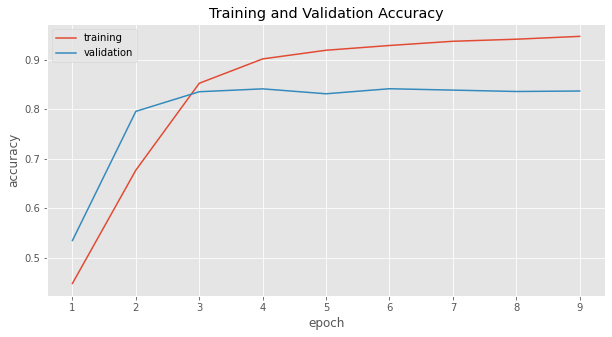

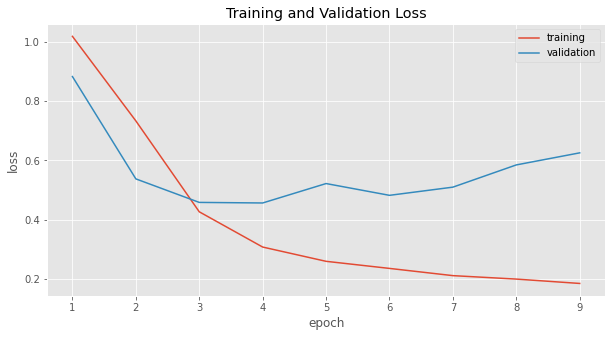

In [141]:
# Visualisasi akurasi dan loss terhadap epoch
epochs = range(1,len(history.history['accuracy'])+1)

# plot accuracy 
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title('Training and Validation Accuracy')
plt.plot(epochs, history.history['accuracy'], label='training')
plt.plot(epochs, history.history['val_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# plot loss 
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title('Training and Validation Loss')
plt.plot(epochs, history.history['loss'], label='training')
plt.plot(epochs, history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()